RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from pathlib import Path
import os
import time

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator
from nlp.conveyor import Conveyor

# View
from IPython.display import Markdown, display

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path, 321)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 9196 articles,  av length: 232 words,  max length: 447 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7521 articles,  av length: 84 words,  max length: 392 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропорт

### Visualizing articles lengths

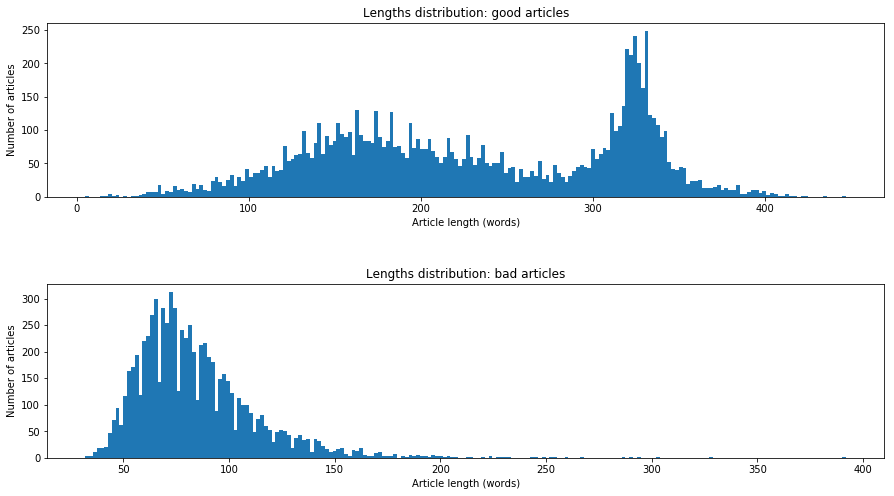

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [3]:
STORAGE_PATH = './storage/model' # to restore model's knowledge later
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary_file_name = f"{STORAGE_PATH}.dictionary"
if Path(dictionary_file_name).is_file():
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Loading dictionary from stored file ({dictionary_file_size} bytes)...")
  with open(dictionary_file_name, 'rb') as fp:
    dictionary, reverse_dictionary, count = pickle.load(fp)
else:
  print('Building dictionary from the corpora...')
  dictionary, reverse_dictionary, count = build_dictionary(all_words)
  print('Saving dictionary on disk for further access...')
  with open(dictionary_file_name, 'wb') as fp:
    pickle.dump((dictionary, reverse_dictionary, count), fp)
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Done. It took {dictionary_file_size} bytes on the disk.")

good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Loading dictionary from stored file (1193403 bytes)...
Top popular words counts: [['UNK', 54382], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59470), ('на', 47402), ('с', 26509), ('что', 22411), ('по', 21900), ('эт', 21548), ('не', 21271), ('из', 16381), ('год', 15883), ('он', 14053)]

Example word: 3144 => слон

Example data: [4, 385, 3, 606, 600, 50, 1918, 1257, 10523, 1302, 540, 1, 89, 359, 255, 2110, 49, 999, 1, 6766]

Validation sizes split train / validation: 9176 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [19]:
batch_size = 2 # Number of articles fed into a model at once
num_unrollings = 10 # Number of recurrent steps

good = [1., 0.] # Representation of first class
bad  = [0., 1.] # Representation of second class

min_size = min(len(good_train_data), len(bad_train_data))
articles_pool = [(data, good) for data in good_train_data[:min_size]] + \
                [(data, bad)  for data in bad_train_data[:min_size]]

print(min_size)
print(len(articles_pool))

conveyors = [Conveyor(articles_pool, num_unrollings) for _ in range(batch_size)]

for _ in range(2):
  bundle = conveyors[0].next()
  print(bundle)
  print([reverse_dictionary[index] for index in bundle[0]])
conveyors[0].rewind()

batches = BatchIterator(10, good_train_data, bad_train_data, good, bad)

for i in range(20):
  batch = batches.next()
  if i > 17:
    print(batch)
    print([reverse_dictionary[index] for index in batch[0]])

batches.rewind()

7501
15002
([33, 90, 617, 5927, 1244, 23, 6299, 2, 44, 1], [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['об', 'работ', 'предполага', 'пересмотр', 'представлен', 'о', 'вакуум', '.', 'одн', ',']
([1836, 1014, 2472, 17340, 12, 0, 516, 19, 811, 18], [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['выполнен', 'физик', 'майкл', 'маккалош', 'из', 'UNK', 'университет', '(', 'великобритан', ')']
[[6, 3952, 2, 4, 13, 2753, 1807, 3877, 2575, 1206], [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
['на', 'трансфер', '.', 'num', 'год', 'реа', 'покупа', 'криштиан', 'роналд', 'барселон']
[[3669, 21488, 11946, 2, 4, 756, 21489

## 2. LSTM Model

In [27]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
# hidden_layer_size = 32

graph = tf.Graph()
with graph.as_default():

  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ix')
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='im')
  ib = tf.Variable(tf.zeros([1, num_nodes]), name='ib')
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='fx')
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='fm')
  fb = tf.Variable(tf.zeros([1, num_nodes]), name='fb')
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ox')
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='om')
  ob = tf.Variable(tf.zeros([1, num_nodes]), name='ob')
  # Memory cell: input, state and bias.
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='cx')
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='cm')
  cb = tf.Variable(tf.zeros([1, num_nodes]), name='cb')
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1), name='w')
  b = tf.Variable(tf.zeros([num_classes]), name='b')
  # w = tf.Variable(tf.truncated_normal([num_nodes, hidden_layer_size], -0.1, 0.1), name='w')
  # b = tf.Variable(tf.zeros([hidden_layer_size]), name='b')
  # hw = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], -0.1, 0.1), name='hw')
  # hb = tf.Variable(tf.zeros([num_classes]), name='hb')
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs   = tf.placeholder(tf.int32,   shape=[batch_size, num_unrollings])
  train_clearers = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings])
  train_labels   = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings, num_classes])
  # train_inputs   = tf.placeholder(tf.int32,   shape=[num_unrollings])               # old
  # train_clearers = tf.placeholder(tf.float32, shape=[num_unrollings])               # old
  # train_labels   = tf.placeholder(tf.float32, shape=[num_unrollings, num_classes])  # old



  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  embedded_batch = tf.nn.embedding_lookup(embeddings, train_inputs)
  lstm_inputs = tf.unstack(embedded_batch, axis=1) # list of ~ (batch_size, embedding_size)
  lstm_state_clearers = tf.unstack(train_clearers, axis=1) # list of ~ (batch_size, )
  # lstm_inputs = tf.unstack(embedded_batch, axis=0) # old
  # lstm_state_clearers = tf.unstack(train_clearers, axis=0) # old

  for lstm_input_batch, state_clearers_batch in zip(lstm_inputs, lstm_state_clearers):
    # reshaped_lstm_input = tf.reshape(lstm_input_batch, (1, embedding_size)) # old
    # print(f"reshaped_lstm_input.shape: {reshaped_lstm_input.shape}")        # old
    # output, state = lstm_cell(reshaped_lstm_input,                          # old
    #                           tf.multiply(state_clearers_batch, output),    # old
    #                           tf.multiply(state_clearers_batch, state))     # old

    print(f"lstm_input_batch.shape: {lstm_input_batch.shape}")
    reshaped_clearers = tf.reshape(state_clearers_batch, (batch_size, 1))
    output, state = lstm_cell(lstm_input_batch,
                              tf.multiply(reshaped_clearers, output),
                              tf.multiply(reshaped_clearers, state))

    lstm_outputs.append(output)

  print(len(lstm_outputs))
  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    # here we `concat` instead of `stack` because we will not take any recurrent steps from now on
    # joined_output = tf.concat(lstm_outputs, 0)
    joined_output = tf.reshape(tf.stack(lstm_outputs, axis=1), (-1, num_nodes))
    print(f"Each output: {output}")
    print(f"Joined_output: {joined_output}")
    
    joined_labels = tf.reshape(train_labels, (-1, num_classes))

    logits = tf.nn.xw_plus_b(joined_output, w, b)

    # hidden_layer = tf.nn.xw_plus_b(joined_output, w, b)
    # activation = tf.nn.tanh(hidden_layer)
    # logits = tf.nn.xw_plus_b(activation, hw, hb)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=joined_labels,
      logits=logits
    ))



    print(f"joined_labels: {joined_labels}")
    print(f"logits: {logits}")


  # Optimizer.
  global_step = tf.Variable(0, trainable=False, name='global_step')
  learning_rate = tf.train.exponential_decay(4.0, global_step, 5000, 0.8, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Storing knowledge to the disk
  saver = tf.train.Saver()

  # Sampling and validation evaluation
  # ==================================
  #
  # Sampling eval: one unrolling, no state clearers
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    # hidden_sample_pred = tf.nn.xw_plus_b(sample_output, w, b)
    # sample_activation = tf.nn.sigmoid(hidden_sample_pred)
    # sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_activation, hw, hb))
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

  valid_labels = tf.placeholder(tf.float32, shape=[None, num_classes])
  valid_logits = tf.placeholder(tf.float32, shape=[None, num_classes])  
  validation_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=valid_labels,
    logits=valid_logits
  ))

lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
lstm_input_batch.shape: (2, 128)
10
Each output: Tensor("mul_29:0", shape=(2, 64), dtype=float32)
Joined_output: Tensor("Reshape_10:0", shape=(20, 64), dtype=float32)
joined_labels: Tensor("Reshape_11:0", shape=(20, 2), dtype=float32)
logits: Tensor("xw_plus_b:0", shape=(20, 2), dtype=float32)


## 3. Training

### Representation helpers

Before we dive into the very learning - let us define some useful helpers to better represent training process.

In [28]:
def print_md(string):
  display(Markdown(string))

def colored_p(text, prediction):
  g, r = [round(probability * 255) for probability in prediction]
  return f"<span style='color: rgb({r}, {g}, 0)'>{text}</span>"

def represent(words, predictions, tail=3):
  result = []
  temp = []
  changed_ago = 0
  for word, label, i in zip(words, predictions, range(len(words))):
    word_to_add = colored_p(word, label)

    if i == 0:
      temp.append(word_to_add)
      continue

    if label_to_color(predictions[i - 1]) == label_to_color(label):
      temp.append(word_to_add)
    else:
      if len(temp) > tail * 2:
        result += temp[:tail] + ['...'] + temp[-tail:]
      else:
        result += temp
      temp = [word_to_add]

  if len(temp) > tail * 2:
    result += temp[:tail] + ['...'] + temp[-tail:]
  else:
    result += temp

  overall_label = colored_p('=>', predictions[-1])
  article = " ".join(result)

  return f"{overall_label} {article}"

def label_to_color(label):
  if abs(label[0] - label[1]) < 0.2: color = 'black'
  elif label[0] > label[1]:          color = 'green'
  else:                              color = 'red'

  return color

def colored(text, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{text}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

### Check if trained yet

In [29]:
is_trained = tf.train.checkpoint_exists(STORAGE_PATH)

print(f"The model will be restored from the storage: {is_trained}")

The model will be restored from the storage: True


### Training process

In [30]:
num_steps = 20001
summary_frequency = 100
# validation_frequencies = [1000, 5000, 30000, 60000, 90000]

if is_trained:
  print("The model has been trained yet. Fetching logs from the storage...")
  with open(f"{STORAGE_PATH}.log", 'rb') as fp:
    losses = pickle.load(fp)
  print("Done")
# else:
  print("Training...")
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    mean_loss = 0
    losses   = []
    v_losses = []
    start_at = time.time()
    for step in range(num_steps):
      feed = ([], [], [])
      for conveyor in conveyors:
        bundle = conveyor.next()
        feed[0].append(bundle[0])
        feed[1].append(bundle[1])
        feed[2].append(bundle[2])

      feed_dict = { train_inputs: feed[0],
                    train_labels: feed[1],
                    train_clearers: feed[2] }

      # batch = batches.next()
      # feed_dict = { train_inputs: [batch[0]],
      #               train_labels: [batch[1]],
      #               train_clearers: [batch[2]] }

      _, l, lr = session.run(
        [optimizer, loss, learning_rate], feed_dict=feed_dict)
      mean_loss += l

      if step % summary_frequency == 0:
        if step > 0:
          # The mean loss is an estimate of the loss over the last few batches.
          mean_loss = mean_loss / summary_frequency

#         # ======================================== Validation
#         if step % (summary_frequency * 4) == 0:
#           v_start_at = time.time()

#           for i, article in enumerate(validation_data):
#             logits = []
#             reset_sample_state.run()
#             current_label = good if i % 2 == 0 else bad
#             labels = [current_label] * len(article)

#             for word in article:
#               prediction = sample_prediction.eval({ sample_input: [word] })
#               logits.append(prediction[0])

#           v_loss = validation_loss.eval({ valid_logits: logits, valid_labels: labels })
#           v_losses.append(v_loss)
#           v_taken = (time.time() - v_start_at)
#           print(f"Validation loss: {v_loss:.4f}, taken: {v_taken:.2f} seconds")
#         # ======================================== Validation

        print('Average loss at step %d: %.4f, learning rate: %.4f' % (step, mean_loss, lr))

        losses.append(mean_loss)
        mean_loss = 0

    taken = (time.time() - start_at) / 60
    print(f"Learning finished in {taken:.1f} minutes.")

    # save what have been learned
    saver.save(session, STORAGE_PATH)
    with open(f"{STORAGE_PATH}.log", 'wb') as fp:
      pickle.dump(losses, fp)

The model has been trained yet. Fetching logs from the storage...
Done
Training...
Initialized
Average loss at step 0: 0.7409, learning rate: 4.0000
Average loss at step 100: 0.3155, learning rate: 4.0000
Average loss at step 200: 0.5110, learning rate: 4.0000
Average loss at step 300: 0.6069, learning rate: 4.0000
Average loss at step 400: 0.5028, learning rate: 4.0000
Average loss at step 500: 0.3642, learning rate: 4.0000
Average loss at step 600: 0.3918, learning rate: 4.0000
Average loss at step 700: 0.2704, learning rate: 4.0000
Average loss at step 800: 0.2586, learning rate: 4.0000
Average loss at step 900: 0.3381, learning rate: 4.0000
Average loss at step 1000: 0.3003, learning rate: 4.0000
Average loss at step 1100: 0.2895, learning rate: 4.0000
Average loss at step 1200: 0.3391, learning rate: 4.0000
Average loss at step 1300: 0.1657, learning rate: 4.0000
Average loss at step 1400: 0.1238, learning rate: 4.0000
Average loss at step 1500: 0.3602, learning rate: 4.0000
Avera

Average loss at step 14200: 0.2833, learning rate: 2.5600
Average loss at step 14300: 0.1848, learning rate: 2.5600
Average loss at step 14400: 0.0452, learning rate: 2.5600
Average loss at step 14500: 0.2235, learning rate: 2.5600
Average loss at step 14600: 0.0616, learning rate: 2.5600
Average loss at step 14700: 0.1788, learning rate: 2.5600
Average loss at step 14800: 0.0855, learning rate: 2.5600
Average loss at step 14900: 0.0369, learning rate: 2.5600
Average loss at step 15000: 0.0304, learning rate: 2.0480
Average loss at step 15100: 0.2786, learning rate: 2.0480
Average loss at step 15200: 0.0735, learning rate: 2.0480
Average loss at step 15300: 0.0969, learning rate: 2.0480
Average loss at step 15400: 0.1626, learning rate: 2.0480
Average loss at step 15500: 0.1969, learning rate: 2.0480
Average loss at step 15600: 0.1275, learning rate: 2.0480
Average loss at step 15700: 0.0787, learning rate: 2.0480
Average loss at step 15800: 0.0565, learning rate: 2.0480
Average loss a

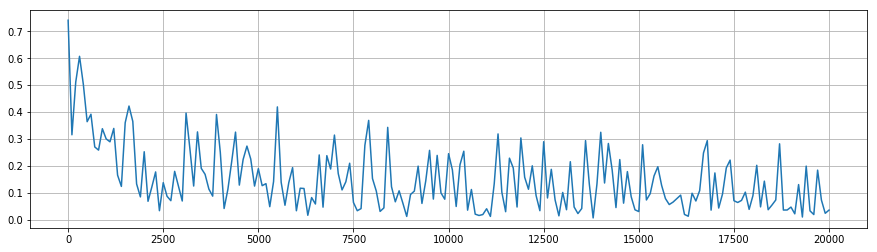

In [31]:
plt.figure().set_size_inches(15, 4)

x_axis  = [n * summary_frequency for n in range(0, len(losses))]
vx_axis = [n * summary_frequency * 4 for n in range(0, len(v_losses))]
# for data in [losses, v_losses]:
plt.plot(x_axis, losses)
plt.plot(vx_axis, v_losses)
plt.grid()

plt.show()

## 4. Having fun

Let us now see the world with neural network's eyes.

First recollect what the model has learned:

In [32]:
def evaluate(articles, session):
  for article in articles:
    session.run(reset_sample_state)
    predicted = []
    for word in article:
      prediction = session.run(sample_prediction, { sample_input: [dictionary[word]] })
      predicted.append(prediction[0])

    print_md(represent(article, predicted))

Let's ask to evaluate some provoking statements:

In [34]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['британск', 'совет', 'взорва', 'аэропорт'],
              ['британск', 'бомб', 'взорва', 'аэропорт'],
              ['бомб', 'взорва', 'аэропорт'],
              ['секс', 'бомб', 'взорва', 'аэропорт'],
              ['британск', 'секс', 'бомб', 'взорва', 'аэропорт']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>британск</span> <span style='color: rgb(0.0, 255.0, 0)'>совет</span> <span style='color: rgb(2.0, 253.0, 0)'>взорва</span> <span style='color: rgb(0.0, 255.0, 0)'>аэропорт</span>

<span style='color: rgb(18.0, 237.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>британск</span> <span style='color: rgb(1.0, 254.0, 0)'>бомб</span> <span style='color: rgb(219.0, 36.0, 0)'>взорва</span> <span style='color: rgb(18.0, 237.0, 0)'>аэропорт</span>

<span style='color: rgb(146.0, 109.0, 0)'>=></span> <span style='color: rgb(163.0, 92.0, 0)'>бомб</span> <span style='color: rgb(254.0, 1.0, 0)'>взорва</span> <span style='color: rgb(146.0, 109.0, 0)'>аэропорт</span>

<span style='color: rgb(114.0, 141.0, 0)'>=></span> <span style='color: rgb(57.0, 198.0, 0)'>секс</span> <span style='color: rgb(169.0, 86.0, 0)'>бомб</span> <span style='color: rgb(254.0, 1.0, 0)'>взорва</span> <span style='color: rgb(114.0, 141.0, 0)'>аэропорт</span>

<span style='color: rgb(20.0, 235.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>британск</span> <span style='color: rgb(0.0, 255.0, 0)'>секс</span> <span style='color: rgb(2.0, 253.0, 0)'>бомб</span> <span style='color: rgb(244.0, 11.0, 0)'>взорва</span> <span style='color: rgb(20.0, 235.0, 0)'>аэропорт</span>

As you can see, the results are quite impressive. The model does recognize the words by their context. Neural network here is at its best.

However, prepending a statement with strongly provoking word `'неизвестный'` irreversibly moves us along a downward spiral toward complete misunderstanding.

In [35]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['неизвестн', 'секс', 'бомб', 'взорва', 'аэропорт'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'аэропорт'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'полност', 'в', 'аэропорт', 'для', 'фотосесс'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'бан'],
              ['неизвестн', 'секс', 'бомб', 'обнаж', 'в', 'британск', 'отел', '.',
               'танц', 'он', 'снял', 'бикин', 'и', 'отправл', 'воздушн', 'поцел', '.']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(236.0, 19.0, 0)'>=></span> <span style='color: rgb(252.0, 3.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>секс</span> <span style='color: rgb(250.0, 5.0, 0)'>бомб</span> <span style='color: rgb(255.0, 0.0, 0)'>взорва</span> <span style='color: rgb(236.0, 19.0, 0)'>аэропорт</span>

<span style='color: rgb(253.0, 2.0, 0)'>=></span> <span style='color: rgb(252.0, 3.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>секс</span> <span style='color: rgb(250.0, 5.0, 0)'>бомб</span> <span style='color: rgb(252.0, 3.0, 0)'>раздел</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(253.0, 2.0, 0)'>аэропорт</span>

<span style='color: rgb(115.0, 140.0, 0)'>=></span> <span style='color: rgb(252.0, 3.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>секс</span> <span style='color: rgb(250.0, 5.0, 0)'>бомб</span> ... <span style='color: rgb(254.0, 1.0, 0)'>полност</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(252.0, 3.0, 0)'>аэропорт</span> <span style='color: rgb(65.0, 190.0, 0)'>для</span> <span style='color: rgb(115.0, 140.0, 0)'>фотосесс</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(252.0, 3.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>секс</span> <span style='color: rgb(250.0, 5.0, 0)'>бомб</span> <span style='color: rgb(252.0, 3.0, 0)'>раздел</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(255.0, 0.0, 0)'>бан</span>

<span style='color: rgb(228.0, 27.0, 0)'>=></span> <span style='color: rgb(252.0, 3.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>секс</span> <span style='color: rgb(250.0, 5.0, 0)'>бомб</span> <span style='color: rgb(254.0, 1.0, 0)'>обнаж</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(21.0, 234.0, 0)'>британск</span> <span style='color: rgb(247.0, 8.0, 0)'>отел</span> <span style='color: rgb(169.0, 86.0, 0)'>.</span> <span style='color: rgb(201.0, 54.0, 0)'>танц</span> <span style='color: rgb(129.0, 126.0, 0)'>он</span> <span style='color: rgb(233.0, 22.0, 0)'>снял</span> <span style='color: rgb(202.0, 53.0, 0)'>бикин</span> <span style='color: rgb(12.0, 243.0, 0)'>и</span> <span style='color: rgb(133.0, 122.0, 0)'>отправл</span> <span style='color: rgb(171.0, 84.0, 0)'>воздушн</span> <span style='color: rgb(243.0, 12.0, 0)'>поцел</span> <span style='color: rgb(228.0, 27.0, 0)'>.</span>